### 衡量预测结果的 BDBR 性能 -> VMAF

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 6)

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',  # 使用衬线字体
    'font.serif': ['Times New Roman'],  # 指定 Times New Roman 字体
    'font.size': 11,
    'text.usetex': False,
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.linewidth': 1,
    'axes.linewidth': 1
})
sns.set_style("whitegrid")
flierprops = dict(marker='o', markersize=2, linestyle='none')

table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
fig_dir   = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"

In [2]:
def rm_outliers(df, cols, threshold=1.5, lower_only=True):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)

        if lower_only:
            df = df[df[col] >= lower_bound]
        else:
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

#### 1. 预测的是 log2vmaf

In [3]:
""" 把每个序列所有的 dataframe 叠在一起 """
import os
import re
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-log2vmaf")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-log2vmaf/{seq}")):
        if not re.search(r"(\d+P)", f):     # 只看一下 cross-preset 的结果
            convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-log2vmaf/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/BDBR/convex_log2vmaf.csv", index=False)

100%|██████████| 1026/1026 [00:01<00:00, 876.69it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_log2vmaf,log2vmaf,vmaf,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,pred_vmaf,convex
0,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,1080P,52,6.125685,6.115314,69.325484,5.460584,5.613493,48.9587,44.035149,69.825654,pred
1,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,1080P,22,6.620212,6.615397,98.046709,12.471467,12.639887,6382.4165,5679.181653,98.374492,pred
2,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,720P,22,6.620614,6.613149,97.894005,11.638866,12.134049,4494.8257,3188.949999,98.401866,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81426,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,360P,27,6.599256,6.605527,97.378215,9.632173,9.615933,784.6650,793.547759,96.955876,fixed
81427,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,540P,27,6.601145,6.615034,98.022035,10.380215,10.374007,1327.0500,1332.772733,97.082862,fixed
81428,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,720P,27,6.601069,6.621266,98.446353,10.814260,10.824000,1812.7950,1800.597665,97.077778,fixed


In [4]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
from fastCAE.metrics.bjontegaard import BD_PSNR, BD_RATE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_vmaf_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["vmaf"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=0
    )
    bd_vmaf_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["vmaf"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_vmaf", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_vmaf"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_log2vmaf.csv", index=False)

3564it [00:08, 429.68it/s]


,seqName,sceneId,regressor,func,input,preset,bd_vmaf,anchor
1,Lecture-42c3,0,Adam,linear,faster,faster,2.959825,fixed
3,Lecture-42c3,0,Adam,linear,faster,medium,2.943872,fixed
5,Lecture-42c3,0,Adam,linear,faster,slower,-2.200210,fixed
7,Lecture-42c3,0,Adam,linear,medium,faster,2.868056,fixed
...,...,...,...,...,...,...,...,...
7124,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,0.000000,cae
7125,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,0.335173,fixed
7126,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,-0.031761,cae
7127,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,0.193466,fixed


,sceneId,bd_vmaf
count,6342.000000,6342.000000
mean,3.446389,0.769567
std,3.529167,2.162655
min,0.000000,-3.683828
25%,1.000000,-0.607349
50%,2.000000,0.470779
75%,6.000000,2.243462
max,11.000000,8.640810


In [5]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_log2vmaf.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_vmaf"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_vmaf", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_vmaf"], threshold=0.75).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_log2vmaf.csv", index=False)

,regressor,func,input,bd_vmaf,anchor
0,Adam,linear,faster,-0.674870,cae
1,Adam,linear,medium,-0.794654,cae
2,Adam,linear,slower,-0.338895,cae
3,Adam,power,faster,-1.730142,cae
...,...,...,...,...,...
104,SGDRegressor,power,slower,0.457477,fixed
105,SGDRegressor,quadratic2,faster,2.475140,fixed
106,SGDRegressor,quadratic2,medium,2.347295,fixed
107,SGDRegressor,quadratic2,slower,2.478813,fixed


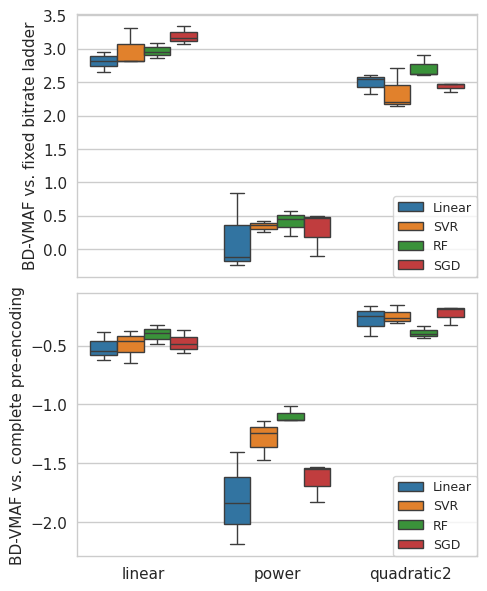

In [6]:
# 直观看一下区别
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(
    ax=axes[0], data=avg_bdbr[(avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-VMAF vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["bd_vmaf"] < 1) & (avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-VMAF vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_log2vmaf.pdf", format="pdf")

#### 2. 预测的是 vmaf

In [7]:
""" 把每个序列所有的 dataframe 叠在一起 """
import pandas as pd
from tqdm import tqdm

seqs = os.listdir(f"{table_dir}/BDBR/rd-vmaf")
convex_df = pd.DataFrame()

for seq in seqs:
    for f in tqdm(os.listdir(f"{table_dir}/BDBR/rd-vmaf/{seq}")):
        if not re.search(r"(\d+P)", f):     # 只看一下 cross-preset 的结果
            convex_df = pd.concat([convex_df, pd.read_csv(f"{table_dir}/BDBR/rd-vmaf/{seq}/{f}")], axis=0)

convex_df = convex_df.reset_index(drop=True) 
display(convex_df)

convex_df.to_csv(f"{table_dir}/BDBR/convex_vmaf.csv", index=False)

100%|██████████| 1022/1022 [00:00<00:00, 1138.74it/s]


,seqName,sceneId,regressor,func,input,preset,size,qp,pred_vmaf,log2vmaf,vmaf,pred_log2bitrate,log2bitrate,bitrate,pred_bitrate,convex
0,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,1080P,52,71.955672,6.115314,69.325484,5.460584,5.613493,48.9587,44.035149,pred
1,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,1080P,22,97.945186,6.615397,98.046709,12.471467,12.639887,6382.4165,5679.181653,pred
2,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,22,97.170751,6.606281,97.429137,9.673069,10.568373,1518.4389,816.364012,pred
3,Lecture-5f3a,0,RandomForestRegressor,quadratic2,faster,slower,360P,27,95.448671,6.577409,95.498656,9.036935,9.001844,512.6550,525.277025,pred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80703,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,1080P,27,97.222074,6.624709,98.681585,11.436992,11.465112,2827.1100,2772.538153,fixed
80704,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,360P,27,97.278462,6.605527,97.378215,9.632173,9.615933,784.6650,793.547759,fixed
80705,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,540P,27,97.758763,6.615034,98.022035,10.380215,10.374007,1327.0500,1332.772733,fixed
80706,Lecture-6d29,3,SGDRegressor,quadratic2,faster,medium,720P,27,97.784233,6.621266,98.446353,10.814260,10.824000,1812.7950,1800.597665,fixed


In [8]:
""" 计算 BDBR -> 1) 相较于传统 CAE (会有 loss);  2) 相较于 fixed QP (会有 gain) """
from fastCAE.metrics.bjontegaard import BD_PSNR, BD_RATE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 8)

grouped = convex_df.groupby(["seqName", "sceneId", "regressor", "func", "input", "preset"])
rows = []
for i, ((seqName, sceneId, regressor, func, inputs, preset), group) in tqdm(enumerate(grouped)):
    pred_convex_df   = group[group["convex"] == "pred"].sort_values(by="bitrate").reset_index(drop=True)
    actual_convex_df = group[group["convex"] == "actual"].sort_values(by="bitrate").reset_index(drop=True)
    fixed_convex_df  = group[group["convex"] == "fixed"].sort_values(by="bitrate").reset_index(drop=True)
    
    bd_vmaf_cae = BD_PSNR(
        actual_convex_df["bitrate"].tolist(), actual_convex_df["vmaf"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=0
    )
    bd_vmaf_fix = BD_PSNR(
        fixed_convex_df["bitrate"].tolist(), fixed_convex_df["vmaf"].tolist(), 
        pred_convex_df["bitrate"].tolist(), pred_convex_df["vmaf"].tolist(), piecewise=0
    )
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf_cae, "cae"])
    rows.append([seqName, sceneId, regressor, func, inputs, preset, bd_vmaf_fix, "fixed"])
    
all_bdbr = pd.DataFrame(rows, columns=["seqName", "sceneId", "regressor", "func", "input", "preset", "bd_vmaf", "anchor"])
all_bdbr = rm_outliers(all_bdbr, cols=["bd_vmaf"], threshold=0.75)
display(all_bdbr)
display(all_bdbr.describe())                  

all_bdbr.to_csv(f"{table_dir}/BDBR/all_rd_vmaf.csv", index=False)

3476it [00:07, 445.93it/s]


,seqName,sceneId,regressor,func,input,preset,bd_vmaf,anchor
0,Lecture-42c3,0,Adam,linear,faster,faster,-2.296571,cae
1,Lecture-42c3,0,Adam,linear,faster,faster,2.028085,fixed
3,Lecture-42c3,0,Adam,linear,faster,medium,2.906591,fixed
4,Lecture-42c3,0,Adam,linear,faster,slower,0.000000,cae
...,...,...,...,...,...,...,...,...
6948,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,0.000000,cae
6949,Lecture-7e40,1,SGDRegressor,quadratic2,slower,medium,0.335173,fixed
6950,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,-0.031761,cae
6951,Lecture-7e40,1,SGDRegressor,quadratic2,slower,slower,0.193466,fixed


,sceneId,bd_vmaf
count,6338.000000,6338.000000
mean,3.508204,0.794654
std,3.535748,1.880110
min,0.000000,-3.059522
25%,1.000000,-0.391408
50%,2.000000,0.410775
75%,6.000000,2.136488
max,11.000000,8.640810


In [9]:
# 看一下不同预测策略 (regressor, func, input) 的效果
table_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/tables"
all_bdbr = pd.read_csv(f"{table_dir}/BDBR/all_rd_vmaf.csv")

grouped = all_bdbr.groupby(["anchor", "regressor", "func", "input"], as_index=False)

rows = []
for (anchor, regressor, func, inputs), group in grouped:
    group = group.reset_index(drop=True)
    rows.append([regressor, func, inputs, group["bd_vmaf"].mean(), anchor])

avg_bdbr = pd.DataFrame(rows, columns=["regressor", "func", "input", "bd_vmaf", "anchor"])
avg_bdbr = rm_outliers(avg_bdbr, cols=["bd_vmaf"], threshold=0.75).reset_index(drop=True)
display(avg_bdbr)

avg_bdbr.to_csv(f"{table_dir}/BDBR/avg_rd_vmaf.csv", index=False)

,regressor,func,input,bd_vmaf,anchor
0,Adam,linear,faster,-0.371112,cae
1,Adam,linear,medium,-0.335311,cae
2,Adam,linear,slower,-0.254422,cae
3,Adam,power,faster,-0.535969,cae
...,...,...,...,...,...
104,SGDRegressor,power,slower,0.565094,fixed
105,SGDRegressor,quadratic2,faster,2.091599,fixed
106,SGDRegressor,quadratic2,medium,2.107599,fixed
107,SGDRegressor,quadratic2,slower,2.047560,fixed


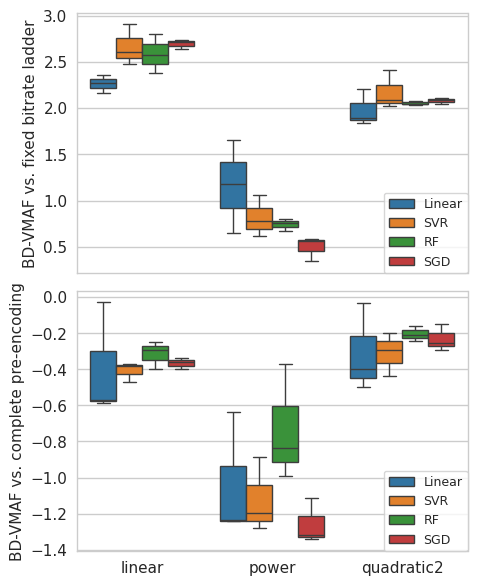

In [10]:
# 直观看一下区别
label_mapping = {
    'Adam': 'Adam',
    'LinearRegression': 'Linear',
    'LinearSVR': 'SVR',
    'RMSProp': 'RMSProp',
    'RandomForestRegressor': 'RF',
    'SGDRegressor': 'SGD'
}

# 画一下 BD-Rate (左边是相比 fixed QP 的, 右边是相比 traditional CAE 的)
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

sns.boxplot(
    ax=axes[0], data=avg_bdbr[(avg_bdbr["bd_vmaf"] < 10) & (avg_bdbr["anchor"] == "fixed") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)
handles, labels = axes[0].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[0].set_xlabel("")
axes[0].set_ylabel("BD-VMAF vs. fixed bitrate ladder")
axes[0].legend(handles, new_labels, borderaxespad=0., loc="lower right")

sns.boxplot(ax=axes[1], data=avg_bdbr[(avg_bdbr["bd_vmaf"] < 1) & (avg_bdbr["anchor"] == "cae") & (avg_bdbr["regressor"] != "Adam") & (avg_bdbr["regressor"] != "RMSProp")], x="func", y="bd_vmaf", hue="regressor", flierprops=flierprops)
handles, labels = axes[1].get_legend_handles_labels()
new_labels = [label_mapping[label] for label in labels]
axes[1].set_xlabel("")
axes[1].set_ylabel("BD-VMAF vs. complete pre-encoding")
axes[1].legend(handles, new_labels, borderaxespad=0., loc="lower right")

fig_dir = "/home/zhaoy/asset-fastCAE/results/vvenc/figs"
plt.tight_layout()
plt.savefig(f"{fig_dir}/BDBR/bd_vmaf.pdf", format="pdf")